# Rejection Sampling

Is a type of exact simulation method. The method works for any distribution in $\mathbf{R}^n$ with a PDF.

Rejection sampling is based on the observation that to sample a random variable in one dimension, one can perform a uniformly random sampling of the two-dimensional Cartesian graph, and keep the samples in the region under the graph of its density function.

First we need a source of random numbers uniformly distributed between 0 and 1.
Given a source of random numbers with such a uniform distribution, we can easily produce a random sequence
with an arbitrary distribution.
Suppose we have a positive function $f(x)$ on the unit interval and we wish to generate points with a weighting proportional to
$f$.
For simplicity assume $f$ is bounded; if not, make a change of variables to make it so.
Without loss of generality, we assume $f(x)$ us bounded by unity.
Using the given random number generator, we obtains a trial number for the first element of our weighted sequence.
Calling this number $x$, we obtain a second random number and accept $x$ if the new random variable is less than $f(x)$.
This is repeated many times to form a sequence of accepted values of $x$.
As the probability of accepting any $x$ is proportional to $f(x)$, the sequence has the desired weighting.

From "Quarks, Gluons, and Lattice", page 132.

Later on below, we will visit the more formal definiton by Casella.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
%load_ext memory_profiler

In [4]:
%%timeit # -r 7 -n 1_000
s = np.random.uniform(0, 1, 100_000)

420 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
%%memit
# see
# https://github.com/pythonprofilers/memory_profiler/blob/a99a3c3b3c2eb01c90f6e14ddfcb85b3e97f9885/memory_profiler.py#L1029
s = np.random.uniform(0, 1, 100_000)

peak memory: 105.44 MiB, increment: 0.12 MiB


In [6]:
%memit np.random.uniform(0, 1, 100)

peak memory: 105.44 MiB, increment: 0.00 MiB


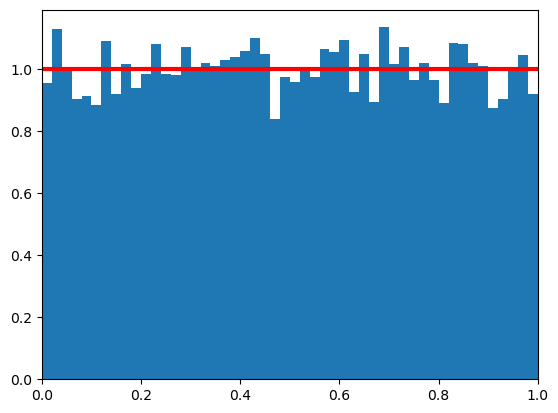

In [2]:
# Plot a uniform distribution.
s = np.random.uniform(0, 1, 10_000)

count, bins, ignored = plt.hist(s, 50, density=True)

plt.plot(bins, np.ones_like(bins), linewidth=3, color='r')
plt.xlim(0, 1)
plt.show()

approximations accepted: 1441
0.1% percentile: -3.090, 99.9% percentile: 3.090


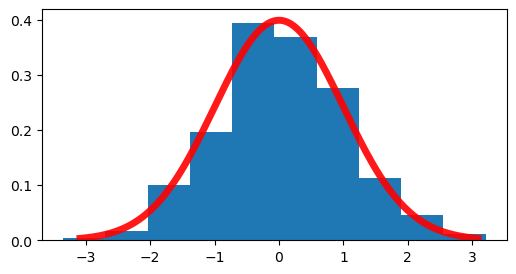

In [4]:
# Simple implementation of the rejection sampling algorithm.
n = 10_000
samples = np.random.uniform(-3.5, 3.5, n)
acceptances = np.random.uniform(0, 1, n)
normalize = 3.5 - -3.5

approximations = []
for i in range(len(samples)):
    x = samples[i]
    f_u = scipy.stats.norm.pdf(x)
        
    if acceptances[i] < f_u:
        approximations.append(x)


print(f"approximations accepted: {len(approximations)}")
print(f"0.1% percentile: {scipy.stats.norm.ppf(0.001):0.3f}, 99.9% percentile: {scipy.stats.norm.ppf(0.999):0.3f}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.linspace(scipy.stats.norm.ppf(0.001), scipy.stats.norm.ppf(0.999), 200)
ax.plot(x, scipy.stats.norm.pdf(x), 'r-', lw=5, alpha=0.9, label="norm pdf")

ax.hist(approximations, bins=10, density=True)

#ax.legend(loc='best', frameon=False)
fig.show()

In [5]:
# Now try generating random variates for some generic function f().
import random

def f(x):
    """Target distribution (proportional to): f(x) = x^2."""
    return x ** 2

def rejection_sampling(num_samples, func):
    """Generates samples from a distribution proportional to f(x) on [0, 1] using rejection sampling."""
    samples = []
    
    while len(samples) < num_samples:
        # Generate a trial sample x from a uniform distribution
        x = random.uniform(0, 1)
        # Generate a second random number for acceptance
        accept_prob = random.uniform(0, 1)
        
        # Accept x if the second random number is less than f(x)
        if accept_prob < func(x):
            samples.append(x)
    
    return samples

# Example usage:
num_samples = 10000
samples = rejection_sampling(num_samples, f)
print(f"Generated {len(samples)} samples.")

Generated 10000 samples.


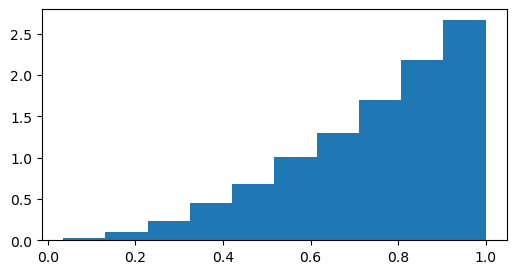

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(samples, bins=10, density=True)

fig.show()

Generated 100000 samples.


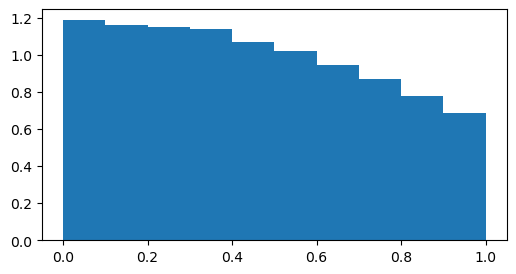

In [7]:
# Example usage: using a cosine distribution.
num_samples = 100000
samples = rejection_sampling(num_samples, np.cos)
print(f"Generated {len(samples)} samples.")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(samples, bins=10, density=True)

fig.show()

In [93]:
import scipy
import functools
import matplotlib.animation as animation
from IPython.display import HTML

In [94]:
def target_beta_dist(x):
    # Parameters for the beta distribution
    alpha = 2.7
    beta = 6.3

    # https://en.wikipedia.org/wiki/Beta_distribution
    # The mode is the point where the density will be the highest (m).
    #mode = (alpha - 1) / (alpha + beta - 2)
    
    # Calculate the maximum density value at the mode.
    return scipy.stats.beta.pdf(x, alpha, beta)

In [97]:
# We generate the data points ahead of time because we cannot animate a scatterplot by adding one point
# per frame. The matplotlib-way to go about it is to instead create a scatterplot, and within that scatterplot
# we can change the size of all points, their locations, or the color. Note that we cannot change the markers being used.
# we will show how to do that below by creating two scatterplots, one using 'o's and the other '^'s.
iterations = 50 * 30

y = np.random.uniform(0, 1, iterations)
u = np.random.uniform(0, 2.67, iterations)
f_y = np.array([target_beta_dist(xi) for xi in y])

# This array is for keeping track of all the u points we did accept.
#points = [u_val if u_val <= f_y_val else f_y_val for u_val, f_y_val in zip(u, f_y) ]

# The 'red' or 'black' values here match the indices of the accepted and rejected points.
colors = ["red" if u_val <= f_y_val else "black" for u_val, f_y_val in zip(u, f_y) ]

# Because we need to use the scatterplot method set_offsets() to update the scatterplot,
# it turns out to be simples to use np.vstack().T to merge the (x,y) arrays
# (the y random variates and the u random variates), and then transpose them into an n x 2 array.
vstack = np.vstack((y, u)).T

In [99]:
fig = plt.figure()
plt.xlim(0, 1)
plt.ylim(0, 2.7)
#graph, = plt.plot([], [], 'o') # another way of creating an empty plot.
graph = plt.scatter([], [])

def animate(i, graph):
    # Note the way we are "skipping frames" here, we will improve upon this on the next animation.
    i = i*30
    
    graph.set_offsets( vstack[:i+1] )
    graph.set_facecolors(colors[:i+1])
    return graph


anim = functools.partial(animate, graph=graph)
ani = animation.FuncAnimation(fig, anim, frames=50)

# Output generated via `matplotlib.animation.Animation.to_jshtml`.
plt.close(fig) # Used to prevent the PNG from showing.
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())

In [75]:
# Soma chatgpt suggested improvements...
y = np.random.uniform(0, 1, 5)
u = np.random.uniform(0, 2.67, 5)
f_y = np.array([target_beta_dist(xi) for xi in y])

print(u)
print(f_y)
test_accepted = np.where(u <= f_y)
print(test_accepted)
test_accepted[0].shape

[2.59471539 2.29384444 0.1125043  0.06507131 1.30403684]
[4.85581300e-03 2.98612102e-15 2.52204208e+00 2.38790562e+00
 2.56345475e+00]
(array([2, 3, 4]),)


(3,)

In [76]:
# Select specific values from the indices of accepted values only if the index meets
# the condition that it is less than 3.
test_accepted[0][test_accepted[0] < 3]

array([2])

In [100]:
import numpy as np
import scipy.stats
import functools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

iterations = 5_000
nth = 100

alpha = 2.7
beta = 6.3

def target_beta_dist(x, a, b):
    return scipy.stats.beta.pdf(x, a, b)

target_dist = functools.partial(target_beta_dist, a=alpha, b=beta)

# https://en.wikipedia.org/wiki/Beta_distribution
# The mode is the point where the density will be the highest (m).
mode = (alpha - 1) / (alpha + beta - 2)
max_density = target_dist(mode)

y = np.random.uniform(0, 1, iterations)
u = np.random.uniform(0, max_density, iterations)
f_y = np.array([target_dist(xi) for xi in y])

accepted_indices = np.where(u <= f_y)[0]
rejected_indices = np.where(u > f_y)[0]

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, round(max_density, 1))

accepted_scatter = ax.scatter([], [], marker='^', color='green', s=10)
rejected_scatter = ax.scatter([], [], marker='o', color='red', s=10)

def init():
    accepted_scatter.set_offsets(np.empty((0, 2)))  # Corrected here
    rejected_scatter.set_offsets(np.empty((0, 2)))  # Corrected here
    return accepted_scatter, rejected_scatter,

def animate(i):
    end_idx = min((i + 1) * nth, iterations)
    
    acc_idx = accepted_indices[accepted_indices < end_idx]
    rej_idx = rejected_indices[rejected_indices < end_idx]
    
    accepted_scatter.set_offsets(np.vstack((y[acc_idx], u[acc_idx])).T)
    rejected_scatter.set_offsets(np.vstack((y[rej_idx], u[rej_idx])).T)
    
    return accepted_scatter, rejected_scatter,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations // nth, blit=True, interval=50)

plt.close(fig)  # Prevents duplicate output
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())

/opt/conda/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [101]:
# Acceptance rate.
accepted_indices.size / iterations

0.3746

In [102]:
mode

0.24285714285714288